In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import scipy.io as spio
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import svm

import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

In [17]:
# Create features data frame for a specific subject

from tkinter import Tk, filedialog
import glob

root = Tk()  # pointing root to Tk() to use it as Tk() in program.
root.withdraw()  # Hides small tkinter window.
root.attributes('-topmost', True)  # Opened windows will be active. above all windows despite selection.
path = filedialog.askdirectory()  # Returns opened path as str



In [18]:
# Choose a folder
dir = glob.glob(os.path.join(path, "*", ""), recursive=True)

In [51]:

def get_Features(dir, i):
    movs = glob.glob(os.path.join(dir[i] + "/*.avi"))
    dfh5_file = glob.glob(os.path.join(dir[i] + "/*30000.h5"))
    vidcap = cv2.VideoCapture(movs[0])
    success, image = vidcap.read()
    print("Able to read movie?: " + str(success))
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps

    # load facial points
    dfh5 = pd.read_hdf(dfh5_file[0])

    # Clac Center of mass
    row = dfh5.iloc[[2]]
    row = np.squeeze(row.to_numpy())
    nose = row[:2]
    ear = row[12:14]
    center_of_mass = np.mean([nose, ear], axis=0)

    # Subtract CoM
    dfh5.iloc[:, [0, 3, 6, 9, 12]] -= center_of_mass[0]
    dfh5.iloc[:, [1, 4, 7, 10, 13]] -= center_of_mass[1]

    # convert to np
    pos_df = dfh5.iloc[1:, [0, 1, 3, 4, 6, 7, 9, 10, 12, 13]]

    pos_df.to_csv(os.path.join(dir[i] + "out.csv"))
    pos = pos_df.to_numpy()

    # pupil
    dfh5_pupil_file = glob.glob(os.path.join(dir[i] + "/*40000.h5"))
    if dfh5_pupil_file:
        dfh5_pupil = pd.read_hdf(dfh5_pupil_file)

        dist = lambda x, y: np.linalg.norm(x - y)

        pupil = dfh5_pupil.iloc[1:, [0, 1, 3, 4, 6, 7, 9, 10, 12, 13]]
        pupil = pupil.to_numpy()

        # i_up = pupil[:, 0:2] |  i_down = pupil[:, 2:4]  |  i_right = pupil[:, 4:6] |  i_left = pupil[:, 6:8]
        dist_hor = list(map(dist, pupil[:, 0:2], pupil[:, 4:6]))
        dist_ver = list(map(dist, pupil[:, 4:6], pupil[:, 6:8]))
        pos_n_pupil = np.concatenate((pos, dist_hor, dist_ver), axis=1)


    else:
        print("The mouse have no pupil file")
        pos_n_pupil = pos

    return pos_n_pupil, pos_df, fps


def getData(dir, before_q, after_q):
    for i in range(dir.__len__()):
        print("Mouse " + str(i + 1))
        print("------------------")

        pos_n_pupil, pos_df, fps = get_Features(dir, i)

        # run matlab code if necessary

        # get session data
        data = spio.loadmat(os.path.join(dir[i] + 'data.mat'))

        correction = pos_n_pupil.shape[0] / ((data['time'].shape[1] / data['Fs']) * fps)

        tSOS_new = data['tSOS'] * correction
        Lick_times_new = np.ravel(data['Lick_times'] * correction + (
                tSOS_new[0] - np.minimum(data['Go_times'][0, 0], data['NoGo_times'][0, 0])))

        stimuli = np.ravel(np.sort(np.c_[data['Go_times'], data['NoGo_times']]))
        stimuli_type = np.in1d(stimuli, data['Go_times'])

        if len(stimuli) != len(tSOS_new):
            print("--Can't label the cue type\n **SKIP** \n ")
            continue

        # movie interpolation
        r = pd.RangeIndex(0, int((data['time'].shape[1] / data['Fs']) * fps), 1)
        t = pos_df
        t = t.sort_index()
        new_idx = np.linspace(t.index[0], len(r), len(r))
        t = (t.reindex(new_idx, method='ffill', limit=1).iloc[1:].interpolate())

        pos_n_pupil = t.to_numpy()

        # segment to trails
        Lick_times = Lick_times_new * fps
        for idx, seg in enumerate(tSOS_new * fps):
            segment = pos_n_pupil[int(seg - before_q * fps):int(seg), :].reshape(
                [int(before_q * fps) * pos_n_pupil.shape[1]])
            lick_seg = np.any(
                np.ravel(np.where((Lick_times > seg) & (Lick_times < seg + after_q * fps))))
            # seg_mean = np.mean(pos_n_pupil[int(seg - before_q * fps):int(seg), :], axis=0)
            # seg_var = np.var(pos_n_pupil[int(seg - before_q * fps):int(seg), :], axis=0)
            # segment = np.r_[segment, seg_mean, seg_var]

            if idx == 0:
                prv_lick = np.array([0])  # previous segment lick choice as a feature
                x = np.r_[segment, prv_lick]
                y = lick_seg


            else:
                y = np.row_stack((y, lick_seg))
                prv_lick = y[-2] # previous lick choice
                segment = np.r_[segment, prv_lick]
                x = np.row_stack((x, segment))

        lick_bias =  y.sum() / y.shape[0]

        if lick_bias < 0.25 or lick_bias > 0.75:
            print("**biased licker**")
            continue

        # concat this mouse data to the others
        # create empty arrays
        if i == 0:
            X = x
            y_tot = y
            stimuli_tot = stimuli_type



        else:
            X = np.concatenate((X, x), axis=0)

            y_tot = np.concatenate((y_tot, y), axis=0)
            stimuli_tot = np.concatenate((stimuli_tot, stimuli_type), axis=0)

        TP = len(data['Reward_times'][0]) / len(data['Go_times'][0])
        FP = len(data['Punishment_times'][0]) / len(data['NoGo_times'][0])
        TN = 1 - FP
        FN = 1 - TP

        #
        # print("Number of licks events (groundTrues): " + str(
        #     len(data['Punishment_times'][0]) + len(data['Reward_times'][0])))
        # print("Number of licks events (algo): " + str(y.sum()))
        print("Rate of licks: ~" + str(round(100 * y.sum() / y.shape[0])) + "%")
        print("True Positive: " + str(TP))
        print("False Positive: " + str(FP))
        print("Mouse Total Accuracy: " + str((TP + TN) / (TP + TN + FP + FN)))
        print("")

    return X, np.ravel(y_tot), np.ravel(stimuli_tot)


In [52]:
X, y, stimuli_type = getData(dir=dir, before_q=0.5, after_q = 1.5)

Mouse 1
------------------
Able to read movie?: True
The mouse have no pupil file
Rate of licks: ~39%
True Positive: 0.5555555555555556
False Positive: 0.30303030303030304
Mouse Total Accuracy: 0.6262626262626263

Mouse 2
------------------
Able to read movie?: True
The mouse have no pupil file
--Can't label the cue type
 **SKIP** 
 
Mouse 3
------------------
Able to read movie?: True
The mouse have no pupil file
Rate of licks: ~34%
True Positive: 0.5416666666666666
False Positive: 0.21875
Mouse Total Accuracy: 0.6614583333333333

Mouse 4
------------------
Able to read movie?: True
The mouse have no pupil file
Rate of licks: ~39%
True Positive: 0.4857142857142857
False Positive: 0.25925925925925924
Mouse Total Accuracy: 0.6132275132275132

Mouse 5
------------------
Able to read movie?: True
The mouse have no pupil file
Rate of licks: ~44%
True Positive: 0.7272727272727273
False Positive: 0.3157894736842105
Mouse Total Accuracy: 0.7057416267942584

Mouse 6
------------------
Able to 

In [21]:
# smoothing
# from scipy.signal import savgol_filter, filtfilt, ellip
# b, a = ellip(4, 0.01, 120, 0.125)  # Filter to be applied.
#
# X_hat = np.zeros_like(X)
# for i in range(X.shape[0]):
#     X_hat[:,i] = filtfilt(b, a,X[:,i], method="gust")

In [43]:
x = X
# add the stimuli sounds
# moments = x[:,-20:] # take the 2 firsts moments
#
# x = np.zeros_like(x)
# x = np.c_[x, stimuli_type]
# x = np.c_[x, y]


Train accuracy: 0.6289353612167301 || STD: 0.01160904437826317
Test accuracy: 0.5815151515151515 || STD: 0.049458964449035754
Lick Events: ~41% 
No-lick Events: ~59%


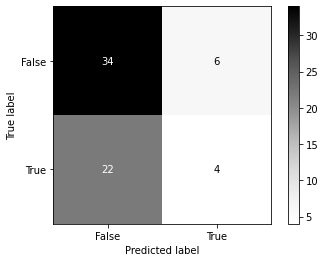

In [46]:
K = 100
acc = np.zeros([K, 2])

for k in range(K):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

    # Feature Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    pca = PCA(n_components=10)
    X_train = pca.fit_transform(X_train, y_train)
    X_test = pca.transform(X_test)

    # Training and Making Predictions
    # classifier = GaussianNB()
    classifier = svm.SVC(kernel='rbf')
    # classifier = RandomForestClassifier(max_depth=2, random_state=0)

    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    acc[k, 0] = accuracy_score(y_test, y_pred)
    train_pred = classifier.predict(X_train)
    acc[k, 1] = accuracy_score(y_train, train_pred)

# Evaluating the Performance
print('Train accuracy: ' + str(np.mean(acc[:, 1])) + ' || STD: ' + str(np.std(acc[:, 1])))
print('Test accuracy: ' + str(np.mean(acc[:, 0])) + ' || STD: ' + str(np.std(acc[:, 0])))

lick_bias = y.sum()/y.shape[0] * 100

print("Lick Events: ~" + str(round(lick_bias)) + "% \nNo-lick Events: ~" +str(round(100- lick_bias)) + "%")


cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greys')
